
Stock Price Prediction 
 


## 1) Setup & Config

In [1]:

# Install (uncomment if needed in your environment)
# %pip install yfinance pandas numpy matplotlib seaborn scikit-learn statsmodels joblib tqdm

import warnings, os, json, math, sys
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import yfinance as yf
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance

from statsmodels.tsa.stattools import adfuller

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.grid"] = True

# Project config
CFG = {
    "ticker": "AAPL",
    "start": "2015-01-01",
    "end": "2024-12-31",
    "horizon": 1,           # predict 1-day ahead close
    "test_size_ratio": 0.2, # last 20% as test
    "cv_splits": 5,
    "output_dir": "outputs"
}

os.makedirs(CFG["output_dir"], exist_ok=True)
print("Config:", json.dumps(CFG, indent=2))


Config: {
  "ticker": "AAPL",
  "start": "2015-01-01",
  "end": "2024-12-31",
  "horizon": 1,
  "test_size_ratio": 0.2,
  "cv_splits": 5,
  "output_dir": "outputs"
}


In [17]:
df = yf.download("AAPL", start="2020-01-01", end="2023-01-01")
print(df.columns)


[*********************100%***********************]  1 of 1 completed

MultiIndex([( 'Close', 'AAPL'),
            (  'High', 'AAPL'),
            (   'Low', 'AAPL'),
            (  'Open', 'AAPL'),
            ('Volume', 'AAPL')],
           names=['Price', 'Ticker'])


## 2) Data Ingestion

In [18]:

def load_yfinance(ticker, start, end):
    df = yf.download(ticker, start=start, end=end)
    df = df.dropna()
    df.reset_index(inplace=True)
    
    # agar Adj Close nahi h to Close use kar lo
    if "Adj Close" in df.columns:
        df.rename(columns={"Adj Close": "AdjClose"}, inplace=True)
    else:
        df["AdjClose"] = df["Close"]  # fallback
    
    return df[["Date","Open","High","Low","Close","AdjClose","Volume"]]

df = load_yfinance(CFG["ticker"], CFG["start"], CFG["end"])
print(df.head())
print("Shape:", df.shape)
df.to_csv(os.path.join(CFG["output_dir"], f"{CFG['ticker']}_raw.csv"), index=False)


[*********************100%***********************]  1 of 1 completed

Price        Date       Open       High        Low      Close   AdjClose  \
Ticker                  AAPL       AAPL       AAPL       AAPL              
0      2015-01-02  24.718171  24.729267  23.821668  24.261044  24.261044   
1      2015-01-05  24.030269  24.110156  23.391179  23.577579  23.577579   
2      2015-01-06  23.641924  23.839420  23.218081  23.579790  23.579790   
3      2015-01-07  23.788382  24.010288  23.677428  23.910431  23.910431   
4      2015-01-08  24.238856  24.886823  24.121244  24.829126  24.829126   

Price      Volume  
Ticker       AAPL  
0       212818400  
1       257142000  
2       263188400  
3       160423600  
4       237458000  
Shape: (2515, 7)


## 3) Exploratory Data Analysis (EDA) — Visuals

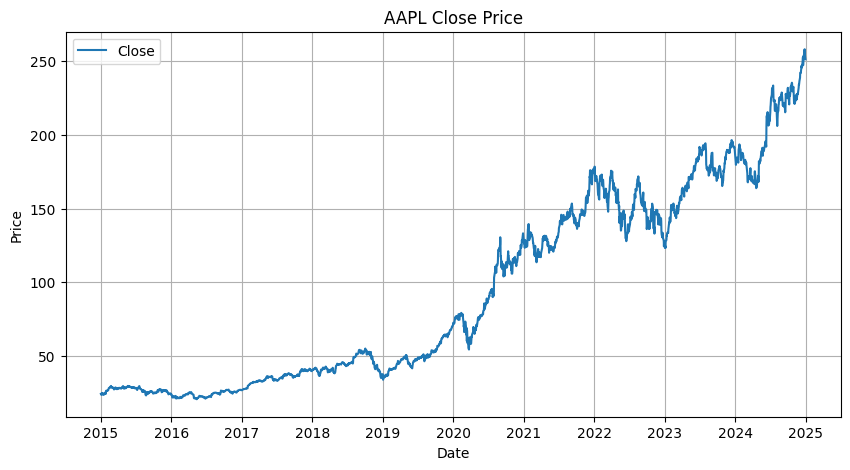

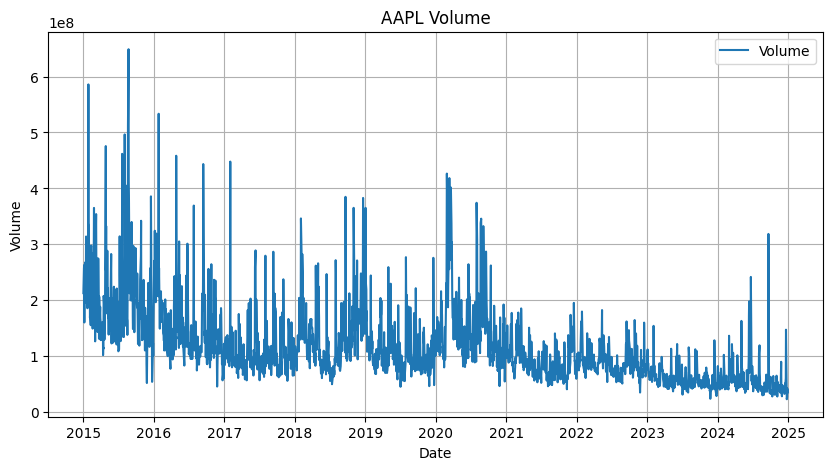

In [19]:

# Closing price
plt.figure()
plt.plot(df["Date"], df["Close"], label="Close")
plt.title(f"{CFG['ticker']} Close Price")
plt.xlabel("Date"); plt.ylabel("Price"); plt.legend()
plt.show()

# Volume
plt.figure()
plt.plot(df["Date"], df["Volume"], label="Volume")
plt.title(f"{CFG['ticker']} Volume")
plt.xlabel("Date"); plt.ylabel("Volume"); plt.legend()
plt.show()


        Date       Open       High        Low      Close   AdjClose     Volume
0 2015-01-02  24.718171  24.729267  23.821668  24.261044  24.261044  212818400
1 2015-01-05  24.030269  24.110156  23.391179  23.577579  23.577579  257142000
2 2015-01-06  23.641924  23.839420  23.218081  23.579790  23.579790  263188400
3 2015-01-07  23.788382  24.010288  23.677428  23.910431  23.910431  160423600
4 2015-01-08  24.238856  24.886823  24.121244  24.829126  24.829126  237458000
Index(['Date', 'Open', 'High', 'Low', 'Close', 'AdjClose', 'Volume'], dtype='object')
        Date       Open       High        Low      Close   AdjClose  \
0 2015-01-02  24.718171  24.729267  23.821668  24.261044  24.261044   
1 2015-01-05  24.030269  24.110156  23.391179  23.577579  23.577579   
2 2015-01-06  23.641924  23.839420  23.218081  23.579790  23.579790   
3 2015-01-07  23.788382  24.010288  23.677428  23.910431  23.910431   
4 2015-01-08  24.238856  24.886823  24.121244  24.829126  24.829126   

      Volume 

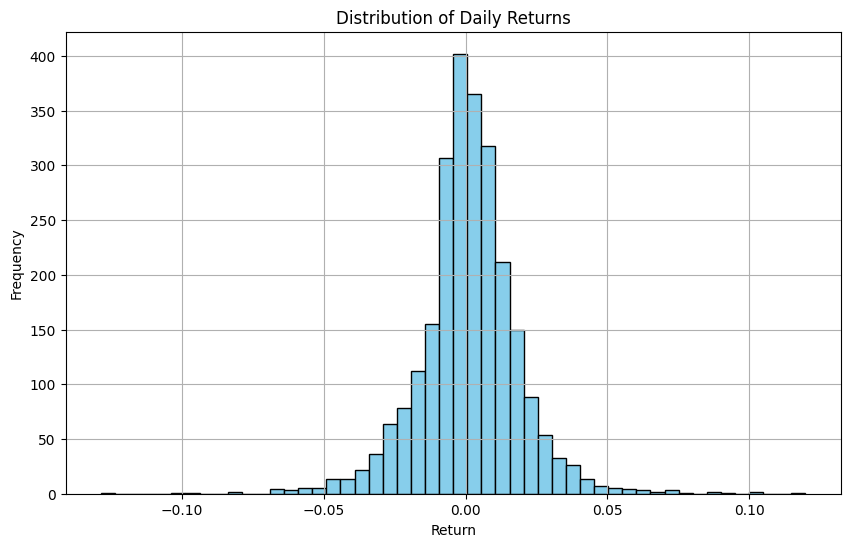

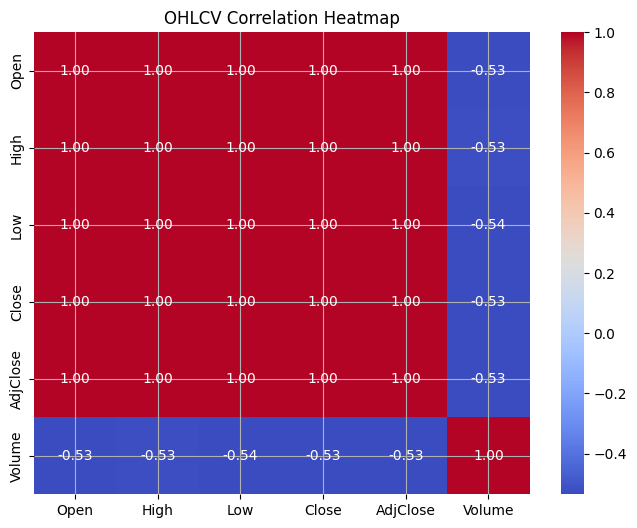

In [6]:
# ========== STEP 2.5: Flatten MultiIndex columns ==========
df.columns = [col[0] if col[0] != 'Price' else col[1] for col in df.columns]

print(df.head())
print(df.columns)   # check karo ki ab simple names hain

# ========== STEP 3: Exploratory Data Analysis (EDA) ==========

eda = df.copy()

# Close se daily returns nikaalo
eda["Return"] = eda["Close"].pct_change()

# Pehle check karo column bana ya nahi
print(eda.head())

# Drop NA values (kyunki first row me Return NaN hota hai)
eda = eda.dropna(subset=["Return"])

# Plot histogram of returns
plt.figure(figsize=(10,6))
plt.hist(eda["Return"], bins=50, color="skyblue", edgecolor="black")
plt.title("Distribution of Daily Returns")
plt.xlabel("Return")
plt.ylabel("Frequency")
plt.show()

# ========== STEP 3.1: Correlation Heatmap ==========
corr = df[["Open","High","Low","Close","AdjClose","Volume"]].corr(numeric_only=True)
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("OHLCV Correlation Heatmap")
plt.show()


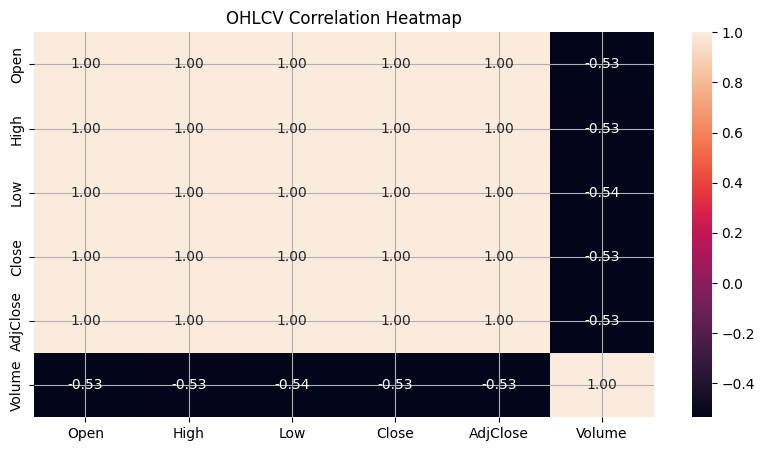

In [7]:

# Correlation heatmap of base OHLCV
corr = df[["Open","High","Low","Close","AdjClose","Volume"]].corr(numeric_only=True)
plt.figure()
sns.heatmap(corr, annot=True, fmt=".2f")
plt.title("OHLCV Correlation Heatmap")
plt.show()


## 4) Feature Engineering (Indicators)

In [8]:

def add_indicators(x: pd.DataFrame) -> pd.DataFrame:
    x = x.copy()
    x["Return"] = x["Close"].pct_change()
    x["LogRet"] = np.log(x["Close"]) - np.log(x["Close"].shift(1))

    # Moving averages / EMA
    x["MA10"] = x["Close"].rolling(10).mean()
    x["MA30"] = x["Close"].rolling(30).mean()
    x["MA100"] = x["Close"].rolling(100).mean()
    x["EMA20"] = x["Close"].ewm(span=20, adjust=False).mean()

    # Bollinger Bands
    x["BB_mid"] = x["Close"].rolling(20).mean()
    x["BB_std"] = x["Close"].rolling(20).std()
    x["BB_upper"] = x["BB_mid"] + 2*x["BB_std"]
    x["BB_lower"] = x["BB_mid"] - 2*x["BB_std"]

    # RSI
    delta = x["Close"].diff()
    up = delta.clip(lower=0)
    down = -1*delta.clip(upper=0)
    roll_up = up.ewm(com=13, adjust=False).mean()
    roll_down = down.ewm(com=13, adjust=False).mean()
    rs = roll_up / roll_down
    x["RSI"] = 100 - (100 / (1 + rs))

    # MACD
    ema12 = x["Close"].ewm(span=12, adjust=False).mean()
    ema26 = x["Close"].ewm(span=26, adjust=False).mean()
    x["MACD"] = ema12 - ema26
    x["MACD_signal"] = x["MACD"].ewm(span=9, adjust=False).mean()

    # ATR (true range proxy)
    x["H-L"] = x["High"] - x["Low"]
    x["H-C"] = (x["High"] - x["Close"].shift(1)).abs()
    x["L-C"] = (x["Low"] - x["Close"].shift(1)).abs()
    x["TR"] = x[["H-L","H-C","L-C"]].max(axis=1)
    x["ATR14"] = x["TR"].rolling(14).mean()

    # Volatility windows
    x["Volatility_10"] = x["Return"].rolling(10).std()
    x["Volatility_30"] = x["Return"].rolling(30).std()

    # Lags
    for lag in [1,2,3,5,7,10]:
        x[f"Close_lag_{lag}"] = x["Close"].shift(lag)
        x[f"Return_lag_{lag}"] = x["Return"].shift(lag)

    # Cleanup helper cols
    x.drop(columns=["H-L","H-C","L-C","TR"], inplace=True)
    return x

fe = add_indicators(df)
fe = fe.dropna().reset_index(drop=True)
print("Features shape:", fe.shape)

# Stationarity check (optional)
is_stat = False
pval = None
try:
    pval = adfuller(fe["LogRet"].dropna(), autolag="AIC")[1]
    is_stat = pval < 0.05
except Exception as e:
    pass

print("ADF p-value (LogRet):", pval, "| Stationary:", is_stat)


Features shape: (2416, 35)
ADF p-value (LogRet): 5.000608463573773e-28 | Stationary: True


## 5) Train/Test Split (Time-based) + Baselines

In [9]:

# Create target
H = CFG["horizon"]
fe["Target"] = fe["Close"].shift(-H)

# Define feature set
drop_cols = ["Date","Target"]
X_cols = [c for c in fe.columns if c not in drop_cols]

# Train/test split by time
cut = int(len(fe) * (1 - CFG["test_size_ratio"]))
train = fe.iloc[:cut].copy()
test  = fe.iloc[cut:].copy()

X_train, y_train = train[X_cols], train["Target"]
X_test,  y_test  = test[X_cols],  test["Target"]

print("Train:", X_train.shape, " Test:", X_test.shape)

# Baseline 1: Naive (predict today's close as tomorrow)
naive_pred = test["Close"].shift(1)   # kal ≈ aaj
naive_pred = naive_pred.dropna()

# Align target bhi dropna ke sath
y_test_aligned = y_test.loc[naive_pred.index].dropna()

# Dono ko align karne ke liye
common_idx = naive_pred.index.intersection(y_test_aligned.index)
naive_pred = naive_pred.loc[common_idx]
y_test_aligned = y_test_aligned.loc[common_idx]

# RMSE
naive_rmse = math.sqrt(mean_squared_error(y_test_aligned, naive_pred))
print("Baseline (Naive) RMSE:", round(naive_rmse, 4))


Train: (1932, 34)  Test: (484, 34)
Baseline (Naive) RMSE: 3.7445


## 6) Models (LR, RF, SVR) with TimeSeriesSplit CV

In [10]:

tscv = TimeSeriesSplit(n_splits=CFG["cv_splits"])

# Pipelines
pipe_lr = Pipeline([
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("model", LinearRegression())
])

pipe_rf = Pipeline([
    ("model", RandomForestRegressor(
        n_estimators=300,
        max_depth=8,
        random_state=42,
        n_jobs=-1
    ))
])

pipe_svr = Pipeline([
    ("scaler", StandardScaler()),
    ("model", SVR())
])

# Quick CV for SVR hyperparameters (keep small grid for speed)
param_svr = {
    "model__C": [1.0, 10.0, 50.0],
    "model__epsilon": [0.01, 0.1, 0.2],
    "model__kernel": ["rbf"]
}

svr_cv = GridSearchCV(pipe_svr, param_grid=param_svr, cv=tscv, scoring="neg_root_mean_squared_error", n_jobs=-1)
svr_cv.fit(X_train, y_train)
print("SVR best params:", svr_cv.best_params_)

# Fit others
pipe_lr.fit(X_train, y_train)
pipe_rf.fit(X_train, y_train)

# Predictions
pred_lr  = pipe_lr.predict(X_test)
pred_rf  = pipe_rf.predict(X_test)
pred_svr = svr_cv.predict(X_test)

def safe_metrics(y_true, y_pred, name):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Remove NaNs from both arrays
    mask = ~np.isnan(y_true)
    y_true_clean = y_true[mask]
    y_pred_clean = y_pred[mask]

    rmse = math.sqrt(mean_squared_error(y_true_clean, y_pred_clean))
    mae = mean_absolute_error(y_true_clean, y_pred_clean)
    r2  = r2_score(y_true_clean, y_pred_clean)

    print(f"{name}: RMSE={rmse:.4f} | MAE={mae:.4f} | R2={r2:.4f}")
    return {"rmse": rmse, "mae": mae, "r2": r2}


print("\nModel Performance on Test:")
m_lr  = safe_metrics(y_test, pred_lr,  "LinearRegression")
m_rf  = safe_metrics(y_test, pred_rf,  "RandomForest")
m_svr = safe_metrics(y_test, pred_svr, "SVR (best)")

# 🔥 Fix Naive Baseline
naive_pred = pd.Series(y_test).shift(1).dropna().values
y_test_naive = y_test[1:]   # align test values
m_nv  = safe_metrics(y_test_naive, naive_pred, "Baseline Naive")



# Pick best by RMSE
all_models = {
    "LinearRegression": (pipe_lr, pred_lr, m_lr),
    "RandomForest": (pipe_rf, pred_rf, m_rf),
    "SVR": (svr_cv.best_estimator_, pred_svr, m_svr)
}
best_name = min(all_models.items(), key=lambda kv: kv[1][2]["rmse"])[0]
best_model, best_pred, best_metrics = all_models[best_name]
print("\nBest model by RMSE:", best_name, "->", best_metrics)


SVR best params: {'model__C': 50.0, 'model__epsilon': 0.01, 'model__kernel': 'rbf'}

Model Performance on Test:
LinearRegression: RMSE=2.6160 | MAE=1.9267 | R2=0.9901
RandomForest: RMSE=30.3304 | MAE=20.6552 | R2=-0.3252
SVR (best): RMSE=50.3068 | MAE=35.2270 | R2=-2.6457
Baseline Naive: RMSE=2.5561 | MAE=1.8922 | R2=0.9905

Best model by RMSE: LinearRegression -> {'rmse': 2.6160415101581074, 'mae': 1.926699700292183, 'r2': 0.9901414689436021}


## 7) Evaluation — Visuals

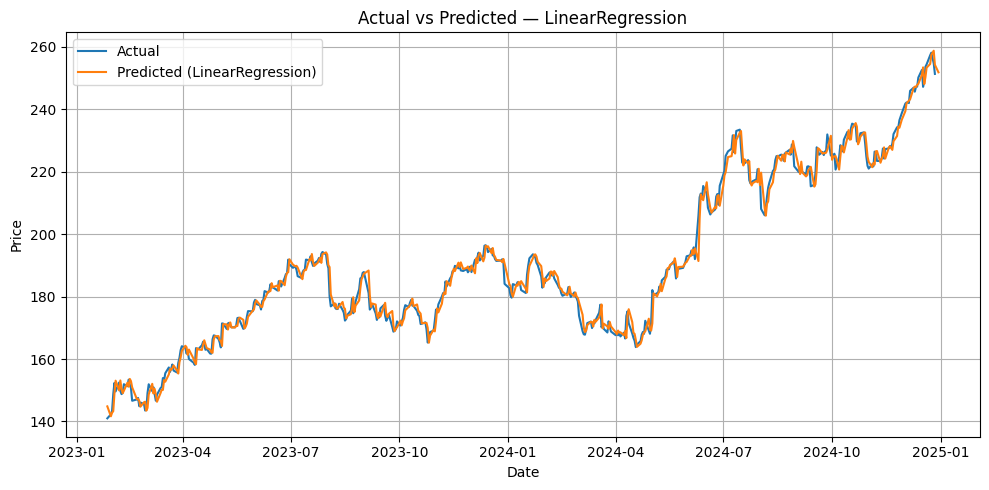

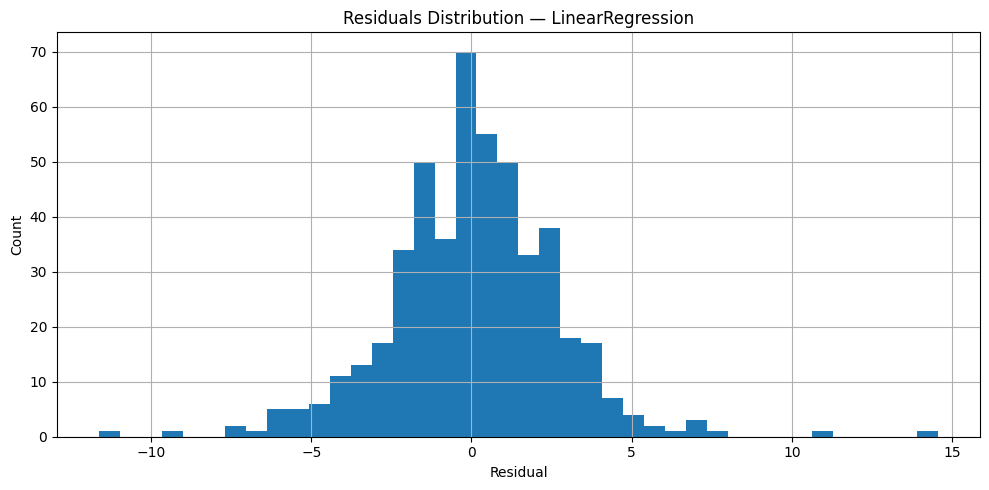

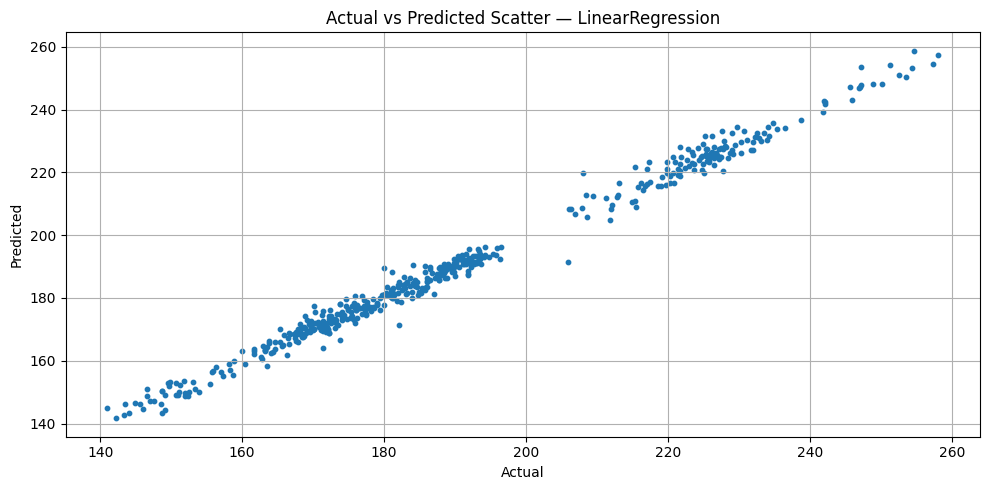

In [11]:

# Actual vs Predicted (Best Model)
plt.figure()
plt.plot(test["Date"], y_test.values, label="Actual")
plt.plot(test["Date"], best_pred, label=f"Predicted ({best_name})")
plt.title(f"Actual vs Predicted — {best_name}")
plt.xlabel("Date"); plt.ylabel("Price"); plt.legend()
plt.tight_layout()
plt.show()

# Residuals
residuals = y_test.values - best_pred
plt.figure()
plt.hist(residuals, bins=40)
plt.title(f"Residuals Distribution — {best_name}")
plt.xlabel("Residual"); plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Scatter Actual vs Predicted
plt.figure()
plt.scatter(y_test.values, best_pred, s=10)
plt.title(f"Actual vs Predicted Scatter — {best_name}")
plt.xlabel("Actual"); plt.ylabel("Predicted")
plt.tight_layout()
plt.show()


## 8) Feature Importance (Permutation + RF)

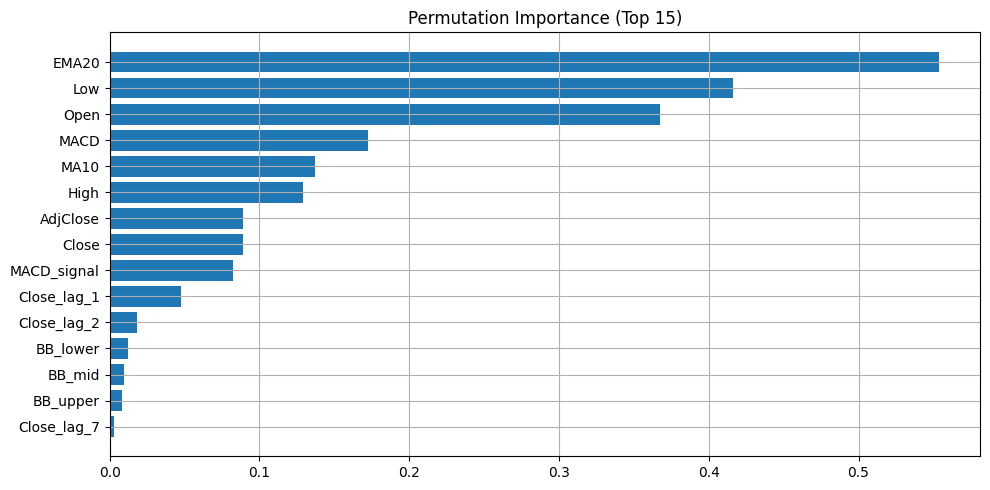

In [12]:

#Permutation importance on a scaled LR pipeline (works for any pipeline)
# Step 8: Feature Importance Analysis

# Clean test set: remove rows with NaN
mask = ~pd.DataFrame(X_test).isna().any(axis=1) & ~pd.Series(y_test).isna()
X_test_clean = X_test[mask]
y_test_clean = y_test[mask]

# Permutation Importance (model-agnostic)
perm = permutation_importance(best_model, X_test_clean, y_test_clean,
                              n_repeats=10, random_state=42, n_jobs=-1)

imp_mean = perm.importances_mean
imp_idx = np.argsort(imp_mean)[::-1]
top = 15

plt.figure()
plt.barh(np.array(X_cols)[imp_idx][:top][::-1], imp_mean[imp_idx][:top][::-1])
plt.title("Permutation Importance (Top 15)")
plt.tight_layout()
plt.show()

# If best model is RandomForest, show feature_importances_
if best_name == "RandomForest":
    rf_model = best_model.named_steps["model"]
    fi = rf_model.feature_importances_
    idx = np.argsort(fi)[::-1][:top]
    plt.figure()
    plt.barh(np.array(X_cols)[idx][::-1], fi[idx][::-1])
    plt.title("RandomForest Feature Importances (Top 15)")
    plt.tight_layout()
    plt.show()



## 9) Forecasting (Tomorrow + Next 7/14 days)

In [13]:

# Prepare last row features for tomorrow prediction
last_row = fe.iloc[[-1]][X_cols]
tomorrow_price = best_model.predict(last_row)[0]
print(f"Predicted price for tomorrow: {tomorrow_price}")

# Multi-step forecast (recursive) for next N days
def multi_step_forecast(feat_df: pd.DataFrame, model, steps: int, x_cols):
    forecasts = []
    temp = feat_df.copy()
    for _ in range(steps):
        # recompute indicators with latest predicted close appended
        new = temp.iloc[[-1]].copy()
        new["Date"] = pd.to_datetime(new["Date"]) + pd.Timedelta(days=1)
        # Use last known close or predicted close to push forward
        new_close = forecasts[-1] if forecasts else model.predict(temp.iloc[[-1]][x_cols])[0]
        new["Close"] = new_close
        # Recompute essential derived features minimally
        new["Return"] = new["Close"].pct_change()  # will be NaN for single row; harmless
        temp = pd.concat([temp, new], ignore_index=True)
        # Fill features for prediction
        Xnew = temp.iloc[[-1]][x_cols].fillna(method="ffill").fillna(0)
        pred = model.predict(Xnew)[0]
        forecasts.append(pred)
    return forecasts

next_7  = multi_step_forecast(fe, best_model, 7, X_cols)
next_14 = multi_step_forecast(fe, best_model, 14, X_cols)

print("Next 7 days forecast:", next_7)
print("Next 14 days forecast:", next_14)


Predicted price for tomorrow: 251.82274185489212
Next 7 days forecast: [np.float64(251.35145969727736), np.float64(251.25001631691154), np.float64(251.22818065168687), np.float64(251.22348052956866), np.float64(251.22246882932055), np.float64(251.22225106106552), np.float64(251.22220418649667)]
Next 14 days forecast: [np.float64(251.35145969727736), np.float64(251.25001631691154), np.float64(251.22818065168687), np.float64(251.22348052956866), np.float64(251.22246882932055), np.float64(251.22225106106552), np.float64(251.22220418649667), np.float64(251.2221940967561), np.float64(251.22219192494165), np.float64(251.2221914574591), np.float64(251.22219135683358), np.float64(251.22219133517396), np.float64(251.22219133051172), np.float64(251.22219132950815)]


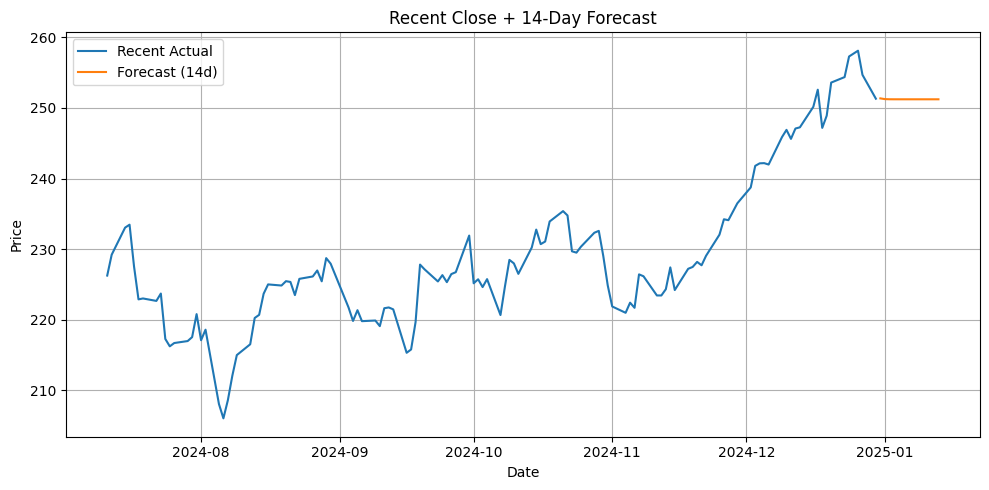

In [14]:

# Plot the last 120 days actual + next 14 forecast
window = 120
recent_dates = fe["Date"].iloc[-window:]
recent_close = fe["Close"].iloc[-window:]

plt.figure()
plt.plot(recent_dates, recent_close, label="Recent Actual")
future_idx = pd.date_range(recent_dates.iloc[-1] + pd.Timedelta(days=1), periods=14, freq="D")
plt.plot(future_idx, next_14, label="Forecast (14d)")
plt.title("Recent Close + 14-Day Forecast")
plt.xlabel("Date"); plt.ylabel("Price"); plt.legend()
plt.tight_layout()
plt.show()


## 10) Simple Strategy Backtest (Signal-based)

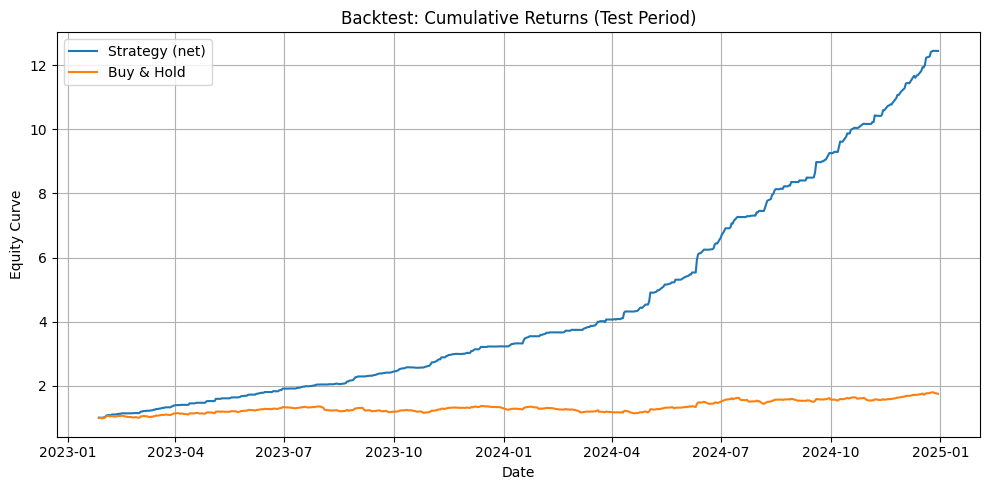

Backtest metrics -> Total: 1144.95% | Sharpe: 9.58 | MaxDD: 6.03%


In [15]:

bt = test.copy()
bt = bt.reset_index(drop=True)
bt["Predicted"] = best_pred
# simple signal: buy if predicted > today's close
bt["Signal"] = (bt["Predicted"] > bt["Close"].shift(1)).astype(int)
bt["Return"] = bt["Close"].pct_change()
# transaction cost per trade
cost = 0.0005
bt["Trade"] = bt["Signal"].diff().abs().fillna(0)
bt["StratRet"] = bt["Signal"] * bt["Return"] - bt["Trade"]*cost
bt["CumStrat"] = (1 + bt["StratRet"].fillna(0)).cumprod()
bt["CumBH"] = (1 + bt["Return"].fillna(0)).cumprod()

plt.figure()
plt.plot(bt["Date"], bt["CumStrat"], label="Strategy (net)")
plt.plot(bt["Date"], bt["CumBH"], label="Buy & Hold")
plt.title("Backtest: Cumulative Returns (Test Period)")
plt.xlabel("Date"); plt.ylabel("Equity Curve"); plt.legend()
plt.tight_layout()
plt.show()

def bt_metrics(rets: pd.Series):
    rets = rets.dropna()
    cum = (1 + rets).cumprod()
    total = cum.iloc[-1] - 1
    sr = (rets.mean()/rets.std()) * np.sqrt(252) if rets.std() != 0 else np.nan
    dd = (cum.cummax() - cum).max()
    return total, sr, dd

total, sharpe, maxdd = bt_metrics(bt["StratRet"].fillna(0))
print(f"Backtest metrics -> Total: {total:.2%} | Sharpe: {sharpe:.2f} | MaxDD: {maxdd:.2%}")


## 11) Save Artifacts (figures, metrics, model)

In [16]:

import joblib

# Save best model
model_path = os.path.join(CFG["output_dir"], f"{CFG['ticker']}_{best_name}_model.pkl")
joblib.dump(best_model, model_path)
print("Saved model to:", model_path)

# Save metrics
metrics_path = os.path.join(CFG["output_dir"], f"{CFG['ticker']}_metrics.json")
with open(metrics_path, "w") as f:
    json.dump({
        "best_model": best_name,
        "metrics": {
            "best": best_metrics,
            "LinearRegression": m_lr,
            "RandomForest": m_rf,
            "SVR": m_svr,
            "Naive": m_nv
        }
    }, f, indent=2)
print("Saved metrics to:", metrics_path)


Saved model to: outputs/AAPL_LinearRegression_model.pkl
Saved metrics to: outputs/AAPL_metrics.json
